In [ ]:
import os
from typing import Annotated, Literal
from pathlib import Path
from dotenv import load_dotenv

# LangChain imports
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import tool
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools.base import TOOL_MESSAGE_BLOCK_TYPES


# LangGraph imports
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict

# Load environment variables from .env file
load_dotenv()

# Access API Keys from environment
OPENAI_API_KEY = "open ai api key"
SERPER_API_KEY = "serper api key"

#### CREATING A TEMPORARY DIRECTORY

In [32]:
# File Management Setup - Using current working directory consistently
WORKING_DIRECTORY = Path.cwd()

#### SEARCH TOOL USING SERPERAPI FOR PHARMA AND FINANCE

In [33]:
# Search Tool
serper_search = GoogleSerperAPIWrapper(serper_api_key=SERPER_API_KEY)

@tool
def enhanced_search(query: str, search_type: str = "search") -> str:
    """Enhanced search using Serper for real-time data and current information."""
    try:
        results = serper_search.results(query)
        formatted_content = []
        
        if 'organic' in results:
            for i, result in enumerate(results['organic'][:8], 1):
                content = f"<Source {i}>\n"
                content += f"Title: {result.get('title', 'N/A')}\n"
                content += f"URL: {result.get('link', 'N/A')}\n"
                content += f"Snippet: {result.get('snippet', 'N/A')}\n"
                content += f"Date: {result.get('date', 'Recent')}\n"
                content += "</Source>\n"
                formatted_content.append(content)
        
        if 'news' in results:
            formatted_content.append("\n<Recent News>\n")
            for i, news in enumerate(results['news'][:3], 1):
                content = f"News {i}: {news.get('title', 'N/A')}\n"
                content += f"Source: {news.get('source', 'N/A')}\n"
                content += f"Date: {news.get('date', 'Recent')}\n"
                content += f"Summary: {news.get('snippet', 'N/A')}\n\n"
                formatted_content.append(content)
            formatted_content.append("</Recent News>\n")
        
        return "\n".join(formatted_content) if formatted_content else "No results found"
    except Exception as e:
        return f"Search error: {str(e)}"

##### CREATE SUMMARY TOOL

In [34]:
@tool
def create_summary(
    content: Annotated[str, "Research content to summarize"],
    file_name: Annotated[str, "File path to save the summary"],
) -> Annotated[str, "Path of the saved summary file"]:
    """Create and save a summary from research content."""
    # Ensure the file has a .txt extension for summaries
    if not file_name.endswith(('.txt', '.md')):
        file_name = file_name.rsplit(".", 1)[0] + ".txt" if "." in file_name else file_name + ".txt"
    
    file_path = WORKING_DIRECTORY / file_name
    with file_path.open("w", encoding='utf-8') as file:
        print("create_summary write")
        file.write(content)
    return f"Summary saved to {file_path}"

##### CREATE DOCUMENT TOOL

In [35]:
@tool
def create_document(
    content: Annotated[str, "Content to be written into the document"],
    file_name: Annotated[str, "File path to save the document"],
) -> Annotated[str, "Path of the saved document file"]:
    """Create and save a document from summary content as a Markdown file."""
    # Ensure the file has a .md extension for Markdown documents
    if not file_name.endswith(".md"):
        file_name = file_name.rsplit(".", 1)[0] + ".md" if "." in file_name else file_name + ".md"
        
    file_path = WORKING_DIRECTORY / file_name
    with file_path.open("w", encoding='utf-8') as file:
        file.write(content)
    return f"Document saved to {file_path}"

##### READ FILE TOOL

In [36]:
@tool
def read_file(
    file_name: Annotated[str, "File path to read"],
) -> str:
    """Read the specified file from the working directory."""
    try:
        file_path = WORKING_DIRECTORY / file_name
        with file_path.open("r", encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        return f"File {file_name} not found in {WORKING_DIRECTORY}"
    except Exception as e:
        return f"Error reading file {file_name}: {str(e)}"

##### CREATING STATE

In [37]:
class State(MessagesState):
    next: str

In [38]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> callable:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )
    
    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: Literal[*options]
    
    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END
        return Command(goto=goto, update={"next": goto})
    
    return supervisor_node

##### INITIALIZING A MODEL

In [ ]:
llm = ChatOpenAI(
            model="gpt-4o-mini",
            openai_api_key="open ai api key",
            #openai_api_base=os.getenv("BASE_URL"),
        )

### RESEARCH TEAM

##### MEDICAL RESEARCH REACT AGENT

In [40]:
# Medical/Pharma Research Agent
medical_research_agent = create_react_agent(
    llm, 
    tools=[enhanced_search],
    prompt="You are a medical and pharmaceutical research specialist. Use the enhanced_search tool to find the most current and real-time information on medical, healthcare, pharmaceutical, and biotech topics. Focus on recent developments, breaking news, clinical studies, regulatory updates, and industry trends. Provide detailed research on health-related queries with emphasis on current data."
)

In [41]:
def medical_research_node(state: State) -> Command[Literal["research_supervisor"]]:
    result = medical_research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="medical_researcher")
            ]
        },
        goto="research_supervisor",
    )

##### FINANCE REASEARCH AGENT

In [42]:
finance_research_agent = create_react_agent(
    llm, 
    tools=[enhanced_search],
    prompt="You are a financial research specialist. Use the enhanced_search tool to find real-time and current information on finance, economics, markets, investments, and business topics. Focus on live market data, breaking financial news, economic indicators, company financials, and investment opportunities. Provide detailed research on financial queries with emphasis on real-time data."
)

In [43]:
def finance_research_node(state: State) -> Command[Literal["research_supervisor"]]:
    result = finance_research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="finance_researcher")
            ]
        },
        goto="research_supervisor",
    )

#### MAKING RESEARCH TEAM SUPERVISOR

In [44]:
research_supervisor_node = make_supervisor_node(llm, ["medical_researcher", "finance_researcher"])

##### COMPILING THE SUBGRAPH WHICH IS BASICALLY THE RESEARCH AGENT

In [45]:
# Build Research Team Graph
research_builder = StateGraph(State)
research_builder.add_node("research_supervisor", research_supervisor_node)
research_builder.add_node("medical_researcher", medical_research_node)
research_builder.add_node("finance_researcher", finance_research_node)
research_builder.add_edge(START, "research_supervisor")
research_graph = research_builder.compile()

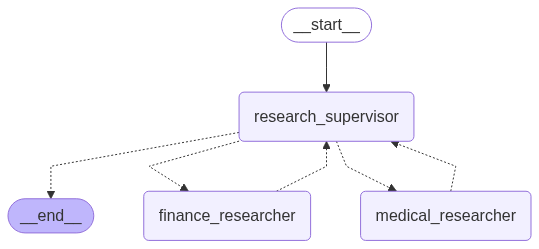

In [46]:
research_builder.compile()

### GENERATOR TEAM

##### SUMMARY REACT AGENT

In [47]:
summary_agent = create_react_agent(
    llm,
    tools=[create_summary, read_file],
    prompt="You are a content summarizer. When given research content, create a concise summary and ALWAYS save it using the create_summary tool with an appropriate filename."
)

In [48]:
def summary_node(state: State) -> Command[Literal["generator_supervisor"]]:
    result = summary_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="summarizer")
            ]
        },
        goto="generator_supervisor",
    )

#### DOCUMENT GENERATOR AGENT

In [49]:
doc_generator_agent = create_react_agent(
    llm,
    tools=[create_document, read_file],
    prompt="You are a document generator. Read summary files using read_file tool, then create comprehensive documents and ALWAYS save them using the create_document tool with an appropriate filename."
)

In [50]:
def doc_generator_node(state: State) -> Command[Literal["generator_supervisor"]]:
    result = doc_generator_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_generator")
            ]
        },
        goto="generator_supervisor",
    )


##### MAKING THE GENERATOR TEAM SUPERVISOR

In [51]:
generator_supervisor_node = make_supervisor_node(llm, ["summarizer", "doc_generator"])

##### COMPILING THE SUBGRAPH WHICH IS BASICALLY A GENERATOR AGENT

In [52]:
generator_builder = StateGraph(State)
generator_builder.add_node("generator_supervisor", generator_supervisor_node)
generator_builder.add_node("summarizer", summary_node)
generator_builder.add_node("doc_generator", doc_generator_node)
generator_builder.add_edge(START, "generator_supervisor")
generator_graph = generator_builder.compile()

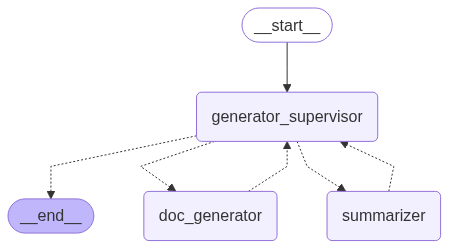

In [53]:
generator_builder.compile()

#### AS WE BUILT OUR TEAMS AND BASIC COMPONENTS NOW LETS INTEGRATE THIS WITH TOP MOST SUPERVISOR

##### TOP LEVEL SUPERVISOR

In [54]:
main_supervisor_node = make_supervisor_node(llm, ["research_team", "generator_team"])

##### RESEARCH TEAM

In [55]:
def call_research_team(state: State) -> Command[Literal["main_supervisor"]]:
    """Call the research team and return results to main supervisor."""
    response = research_graph.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, 
                    name="research_team"
                )
            ]
        },
        goto="main_supervisor",
    )

##### GENERATOR TEAM

In [56]:
def call_generator_team(state: State) -> Command[Literal["main_supervisor"]]:
    """Call the generator team and return results to main supervisor."""
    response = generator_graph.invoke({"messages": state["messages"]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, 
                    name="generator_team"
                )
            ]
        },
        goto="main_supervisor",
    )

##### COMPILING THE FINAL GRAPH

In [57]:
main_builder = StateGraph(State)
main_builder.add_node("main_supervisor", main_supervisor_node)
main_builder.add_node("research_team", call_research_team)
main_builder.add_node("generator_team", call_generator_team)
main_builder.add_edge(START, "main_supervisor")
main_graph = main_builder.compile()

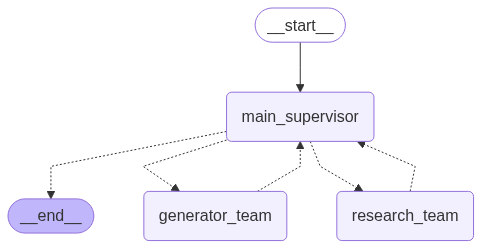

In [58]:
main_builder.compile()

In [59]:
def run_hierarchical_system(query: str):
    """Run the hierarchical agent system with a given query."""
    print(f"Processing query: {query}")
    print("=" * 50)
    
    for step in main_graph.stream(
        {"messages": [("user", query)]},
        {"recursion_limit": 100}
    ):
        print(step)
        print("-" * 30)

In [62]:
run_hierarchical_system("what steps do you suggest a beginner while starting their trading journey?")

Processing query: what steps do you suggest a beginner while starting their trading journey?
{'main_supervisor': {'next': 'research_team'}}
------------------------------


Task research_supervisor with path ('__pregel_pull', 'research_supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'research_team': {'messages': [HumanMessage(content='Starting a trading journey can be exciting and potentially profitable, but it also comes with risks. Here are several steps that a beginner should consider taking to navigate this journey effectively:\n\n1. **Educate Yourself**:\n   - **Read Books and Articles**: Look for reputable sources that cover both fundamental and technical analysis.\n   - **Online Courses**: Platforms like Coursera and Udemy offer courses on trading strategies and market analysis.\n   - **Follow Market News**: Stay updated with financial news through websites like Bloomberg, CNBC, or MarketWatch.\n\n2. **Understand the Market**:\n   - Learn about different markets (stocks, forex, commodities, crypto) and choose which one interests you.\n   - Familiarize yourself with financial instruments like shares, ETFs, options, and futures.\n\n3. **Set Clear Goals**:\n   - Define what you want to achieve with trading (short-term gains, long-term investment).\n   - Set r

Task generator_supervisor with path ('__pregel_pull', 'generator_supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'generator_team': {'messages': [HumanMessage(content='I have created and saved the document titled "Beginner\'s Guide to Starting a Trading Journey". You can find it [here](sandbox:/C:/Users/Revathi/Documents/GenAIProjects/MedicalHierarichalAgent/beginner_trading_guide.md). This guide includes essential steps for beginners to navigate their trading journey effectively.', additional_kwargs={}, response_metadata={}, name='generator_team', id='d8ae4aa9-6e1f-4a8e-8c53-aa5053bab4bd')]}}
------------------------------


Task main_supervisor with path ('__pregel_pull', 'main_supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


{'main_supervisor': {'next': '__end__'}}
------------------------------
